In [2]:
# Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed


## Load dataset and drop irrelevant columns from the dataset 

In [12]:
df = pd.read_csv('Mastercard_stock_history.csv', index_col="Date", parse_dates=["Date"]).drop(["Dividends", "Stock Splits"], axis=1)
df.head()


,Open,High,Low,Close,Volume
Date,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000


In [13]:
# analyze the data in depth

df.describe()

,Open,High,Low,Close,Volume
count,3872.000000,3872.000000,3872.000000,3872.000000,3.872000e+03
mean,104.896814,105.956054,103.769349,104.882714,1.232250e+07
std,106.245511,107.303589,105.050064,106.168693,1.759665e+07
min,3.748967,4.102467,3.739664,4.083861,6.411000e+05
25%,22.347203,22.637997,22.034458,22.300391,3.529475e+06
50%,70.810079,71.375896,70.224002,70.856083,5.891750e+06
75%,147.688448,148.645373,146.822013,147.688438,1.319775e+07
max,392.653890,400.521479,389.747812,394.685730,3.953430e+08


In [14]:
# Check missing value

df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

- No missing values

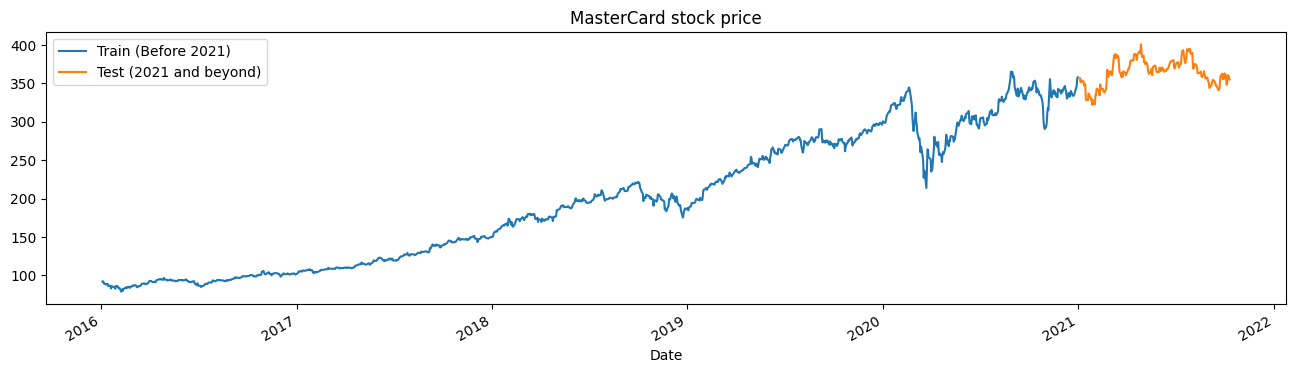

In [15]:
# tstart and tend are time limits in years. 

tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(df,tstart,tend)


## Data Preprocessing

In [16]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(df, tstart, tend)

## use the MinMaxScaler function to standardize our training set

In [17]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

### Here I will use 30 n_steps. We can also reduce or increase the number of steps to optimize model performance.

In [18]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 30
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)


In [19]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)


## LSTM Model

The model consists of a single hidden layer of LSTM and an output layer. You can experiment with the number of units, as more units will give you better results. For this experiment, we will set LSTM units to 125, tanh as activation, and set input size.

In [20]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

/home/jagannath/100OfCode/env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model_lstm.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0347
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.5937e-04
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.9106e-04
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.1538e-04
Epoch 13/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.9897e-04
Epoch 14/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.1113e-04
Epoch 15/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

## Results
I am going to repeat preprocessing and normalize the test set. First of all I will transform then split the dataset into samples, reshape it, predict, and inverse transform the predictions into standard form.

In [22]:
dataset_total = df.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


##### The plot_predictions function will plot a real versus predicted line chart. This will help us visualize the difference between actual and predicted values.
##### The return_rmse function takes in test and predicted arguments and prints out the root mean square error (rmse) metric.

In [23]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


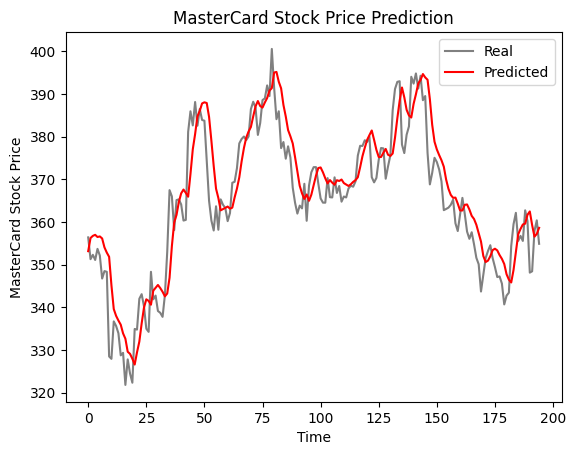

In [24]:
plot_predictions(test_set,predicted_stock_price)


In [25]:
return_rmse(test_set,predicted_stock_price)


The root mean squared error is 7.12.


The results look promising as the model got 7.12 rmse on the test dataset.

## GRU Model

We are going to keep everything the same and just replace the LSTM layer with the GRU layer to properly compare the results. The model structure contains a single GRU layer with 125 units and an output layer.



In [26]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

/home/jagannath/100OfCode/env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 125)            │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model_gru.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0636
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.3398e-04
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.4678e-04
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.7785e-04
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.3123e-04
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.9196e-04
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.2905e-04
Epoch 13/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.5684e-04
Epoch 14/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.8844e-04
Epoch 15/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 

The model has successfully trained with 30 epochs and a batch size of 32.

## Results

As we can see, the real and predicted values are relatively close. The predicted line chart almost fits the actual values.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


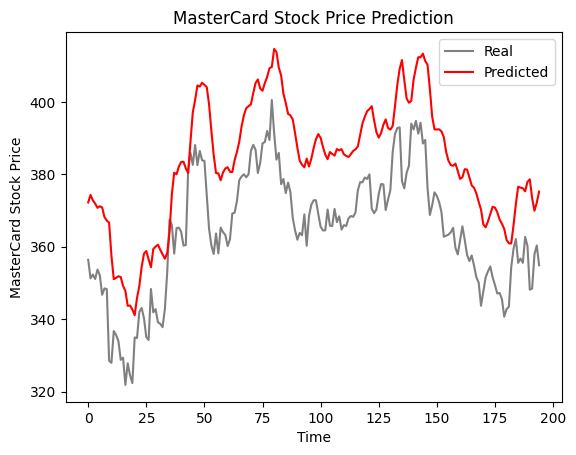

In [28]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)


In [29]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 19.81.
